<h1><center>DALLAS CRIME DATA</center></h1>
<h2><center>MSDS 7331 Mini Project</center></h2>
<h2><center>SVM and Logistic Regression Modeling</center></h2>

<h4><center>Team Members</center></h4>

           Yejur Singh Kunwar           Bin Yu               Vivek Viswanathan          Kevin Mendonsa
              Dallas, TX               Dallas, TX               Dallas, TX                Irvine, CA

## Introduction
##### Data Description
The Dallas Crime Incident data set that is used in the Mini Project acts as a bridge between the citizens of Dallas and the Dallas PD. It represents the Dallas Police Public Data - RMS Incidents from June 1, 2014 to September 7, 2018. 
For purposes of this Mini Project, the main dataframe that is trimmed based on the analysis performed as part of Lab 1. The details of the data quality clean up and choice of columns have been detailed in the Lab 1 notebook link provided below.

**Lab 1 Notebook Link -** https://github.com/wtubin/MSDS7331-Data-Mining/MSDS7331_Data_Mining_Lab1_Data-Viz_Pre-Processing.ipynb
**Note -** The structure of the document will closely follow the phases of the CRISP-DM Modeling Phase.

##### Objective

The objective of this unit is to perform Logistic Regression and Support Vector Machines categorization on the chosen data set and optimize the parameters in order to improve the accuracy of the model.

**GitHub Repository containing the artifacts -** https://github.com/wtubin/MSDS7331-Data-Mining

**Location of the raw (compressed) data file -** https://github.com/wtubin/MSDS7331-Data-Mining/Police_Incidents.7z 

As part of this analysis, we are attempting to train and test our classification model 5 different ways using 3 modeling techniques:

- Logistic Regression, with manual variable reduction
- Logistic Regression, using GridSearchCV, with Manual Feature reduction
- Logistic Regression, using GridSearchCV, with Recursive Feature Elimination (RFE)
- Support Vector Machine (SVM), with Manual Feature reduction
- Stochastic Gradient Descent (SGDClassifier)

The EvaluateClassifierEstimator function from Dr. Drew's NC Education project GitHub has been modified so as to output Accuracy, Precision, Recall, and F-Value. We'll use these parameters to evaluate the effectiveness of our model.

## Data Preparation

The dataset is loaded into the workspace as a data frame and undergoes transformation or standardization before being fed into model. The attributes with zero variance (closer) or those attributes that does not have value in predicting the respose variable are removed. For example attributes like beats, sector, Location1, etc. serves no purpose for our model. 

Once the unwanted attributes are removed, we're left with attributes that can contribute to our model. Since these attributes will help us classify the Response, going forward, we will refer to the Explanatory variables as Features.

Then dataset is split into explanatory, referred to as inci_X (Feature) and response referred to as inci_Y (response: "Arrest_status") for running the models.

        - inci_X : Explanatory variables (Features)
        - inci_Y : Response variable (Arrest_status)

The Features are being scaled to have a mean of 0 and variance of 1 in order to imporve accuracy of the classification models. The data will then be split in to 80/20 training/test set split. To reduce possibility of "overfitting", 10-fold cross validation is being implemented. The GridSearchCV method helps the model search over specified parameters and identify the optimal parameters for model execution. Correlation scores, variance inflaion scores, variance inflation factors (VIFs) and significance will be utilized for manual determination of Features. This will help with feature reduction or feature selection for our final model. The remaining features will also be utilized in other two models: Logistic Regression using GridSearchCV with Recursive Feature Elimination and Support Vector Machine. The scikit-learn GridSearchCV feature will be utilized to adjust model parameters for adjusting class_weight.

The following techniques have been used during the analysis to improve the performance and accuracy.
 - Class balancing using down sampling
 - Removing Multicolinearity by reviewing correlation matrix
 - Removing Multicolinearity by reviewing VIF
 - Scaling the features
 - 10 fold cross validation
 
A brief description of the purpose and outcome of each of the techniques is explained as they are being applied to the data set.

**Note:** As part of Project 1, we had chosen a continous variable (Response Time) as our Response Variable. However, after viewing class videos and additional reading, the project team decided to change to response variable to Arrest Status because we'd be classifying an outcome that has a binary response.

In [1]:
# Importing necessary packages for python
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression
import warnings
import matplotlib.pyplot as plt
import plotly.tools as tls

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', DeprecationWarning)
pd.set_option('mode.chained_assignment', None)

%matplotlib inline

In [2]:
# Importing data from LAB#1 and explore the data
path = "../../Data/" # Generic path
incident = pd.read_csv(path + 'LAB1_completed_Dataset_clean.csv', low_memory= False)

# Data cleaning
incident['Response_time'] = incident['Response_time'].fillna(incident['Response_time'].mean()).astype(np.int)
incident = incident[incident['Call_Received_Hour'].isnull()==False]
incident_NullCols = incident.isnull().sum()
incident_NullCols = incident_NullCols[incident_NullCols > 0]

# Print out the data properties
print(incident.shape)
print('Number of null columns and their counts')
print(incident_NullCols)

(254091, 45)
Number of null columns and their counts
Type_Location                4856
Reporting_Area                155
Beat                           70
Sector                         70
Call_Cleared_Date_Time        165
Call_Dispatch_Date_Time        21
Offense_Status                557
Victim_Condition           233793
Family_Offense                 32
Weapon_Used                 28804
UCR_Offense_Name            14475
UCR_Code                    14475
X_Coordinate                21095
Y_Coordinate                21095
State                         608
Call_Cleared                  165
Call_Dispatch                  21
Latitude                     9755
Longitude                    9755
dtype: int64


### Response Variable Analysis

As part of this analysis, we look at the distinct values and distribution of the response variable. 

Class 0: 229722
Class 1: 24369
Proportion: 9.43 : 1


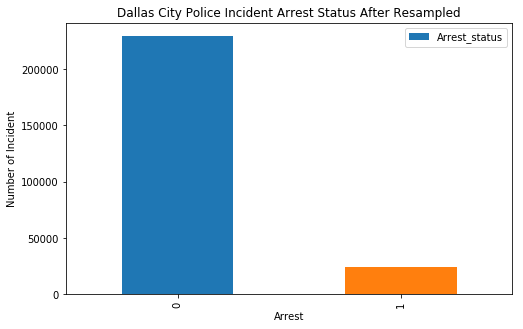

In [3]:
# Explore response variable distribution
from matplotlib.legend import Legend
plt.figure(figsize=(8,5))
target_count = incident.Arrest_status.value_counts()

print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

incident.Arrest_status.value_counts()
incident['Arrest_status'].value_counts().plot(kind='bar')
plt.title("Dallas City Police Incident Arrest Status After Resampled")
plt.ylabel('Number of Incident')
plt.xlabel('Arrest')
plt.legend()



In [4]:
target_count.transpose()

0    229722
1     24369
Name: Arrest_status, dtype: int64

### Resampling (Downsampling) the data set

Based on the above analysis, we have almost 10 times the number of samples for perpetrator not being arrested compared to where an arrest is made. 

In an imbalanced class, we cannot reliably use accuracy to measure performance. This makes training the model very tricky. The model may predict the majority class better and sometimes ignore the minority class completely. 

We perform down-sample by 
1. Separating observations based on class
2. Resample the majority class without replacement after setting the number of samples to match the minorit class count
3. Combine the down-sampled majority class and the original minority class

Finally, we plot the distribution of distinct classes of the response variable to check that it is balanced before proceeding with further analysis.

Source: https://elitedatascience.com/imbalanced-classes

In [5]:
from sklearn.utils import resample

# # Separate majority and minority classes
# incident_majority = incident[incident.Arrest_status==0]
# incident_minority = incident[incident.Arrest_status==1]
 
# # Upsample minority class
# incident_minority_upsampled = resample(incident_minority, 
#                                        replace=True,     # sample with replacement
#                                        n_samples=229722,    # to match majority class
#                                        random_state=123) # reproducible results

    
# # Combine majority class with upsampled minority class
# incident_minority_upsampled = pd.concat([incident_majority, incident_minority_upsampled])

# # Display new class counts
# incident_minority_upsampled.Arrest_status.value_counts()


# DOWNSAMPLE
df_majority = incident[incident.Arrest_status==0]
df_minority = incident[incident.Arrest_status==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=24369,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Arrest_status.value_counts()
# 1    49

1    24369
0    24369
Name: Arrest_status, dtype: int64

In [6]:
# copy the resampled dataset to original incident data frame
incident= df_downsampled.copy()

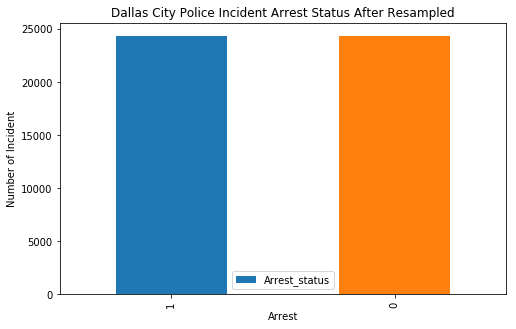

In [7]:
plt.figure(figsize=(8,5))

incident.Arrest_status.value_counts()
incident['Arrest_status'].value_counts().plot(kind='bar')
plt.title("Dallas City Police Incident Arrest Status After Resampled")
plt.ylabel('Number of Incident')
plt.xlabel('Arrest')
plt.legend()

In [8]:
# UCR_Offense_Name change this

incident.loc[:,'UCR_Offense_Name'] = incident['UCR_Offense_Name'].fillna("MISSING")

THEFT_FRAUD     = dict.fromkeys(['THEFT/BMV', 'THEFT ORG RETAIL', 'BURGLARY-RESIDENCE', 'OTHER THEFTS',
                                 'ROBBERY-INDIVIDUAL','THEFT/SHOPLIFT', 'BURGLARY-BUSINESS', 'FORGE & COUNTERFEIT', 
                                 'FRAUD', 'EMBEZZLEMENT','ROBBERY-BUSINESS','THEFT ORG RETAIL'],"THEFT_FRAUD" ) 
MVA_TRAFFIC      =dict.fromkeys(['ACCIDENT MV', 'MOTOR VEHICLE ACCIDENT', 'UUMV', 'TRAFFIC VIOLATION',
                                 'TRAFFIC FATALITY'],"MVA_TRAFFIC" )        
WEAPONS_FIREARMS =dict.fromkeys(['WEAPONS', 'ARSON', 'INJURED FIREARM'], "WEAPONS_FIREARMS")         
ASSUALT          = dict.fromkeys(['ASSAULT','VANDALISM & CRIM MISCHIEF', 'AGG ASSAULT - NFV', 'OFFENSE AGAINST CHILD',
                                  'AGG ASSAULT - FV'], "ASSUALT")
OTHERS_THREATS   = dict.fromkeys(['FOUND', 'OTHERS', 'LOST', 'CRIMINAL TRESPASS', 'DISORDERLY CONDUCT', 
                                  'ANIMAL BITE','INJURED HOME','INJURED PUBLIC', 'TERRORISTIC THREAT', 
                                  'EVADING', 'INJURED OCCUPA', 'ORANIZED CRIME', 'KIDNAPPING', 
                                  'RESIST ARREST','FAIL TO ID', 'HUMAN TRAFFICKING', 'MISSING'], "OTHERS_THREATS")
INTOXICATION     = dict.fromkeys(['DRUNK & DISORDERLY', 'DWI', 'NARCOTICS & DRUGS', 'LIQUOR OFFENSE', 
                                  'INTOXICATION MANSLAUGHTER'],"INTOXICATION")
MURDER_DEATH     = dict.fromkeys(['SUDDEN DEATH&FOUND BODIES','MURDER'], "MURDER_DEATH")
                    

incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(THEFT_FRAUD)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MVA_TRAFFIC)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(WEAPONS_FIREARMS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(ASSUALT)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(OTHERS_THREATS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(INTOXICATION)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MURDER_DEATH)

In [9]:
# # FILTERING OUT UNNECESSARY NULL DATA
incident = incident[incident['Watch']!=0]
incident = incident[(incident['Victim_Age']>=0) & (incident['Victim_Age']<=90)]
incident = incident[incident['Victim_Race']!="Unknown"]
incident = incident[incident['Victim_Type']!="Unknown"]
incident= incident[incident.Number_of_offense != "RP"]

incident = incident[incident['Victim_Gender']!="U"]
incident.loc[:,'IsMale'] = incident.Victim_Gender=='M' 
incident.IsMale = incident.IsMale.astype(np.int)

incident.loc[:,'Social_crime_score'] = incident['Hate_Crime']+incident['Gang_Related_Offense']+incident['Drug_Related']

incident.loc[:,'Victim_Age'] = incident['Victim_Age'].astype(np.int)
# incident.loc[:,'Victim_Age_Group'] = pd.cut(incident.Victim_Age,[-1,18,30,60,999],4,labels=[0,1,2,3])

incident['UCR_Offense_Name'] = pd.Categorical(incident['UCR_Offense_Name']).codes
incident['Day1_of_the_Week'] = pd.Categorical(incident['Day1_of_the_Week']).codes
incident['Division'] = pd.Categorical(incident['Division']).codes
incident['Victim_Type'] = pd.Categorical(incident['Victim_Type']).codes
incident['Victim_Race'] = pd.Categorical(incident['Victim_Race']).codes

incident.loc[:,'Number_of_offense']= incident.Number_of_offense.astype(np.int)

In [10]:
# tmp_df = pd.get_dummies(incident.UCR_Offense_Name,prefix='UCR_Offense_Name')
# incident = pd.concat((incident,tmp_df),axis=1)

In [11]:
incident.columns

Index(['Unnamed: 0', 'Year_of_Incident', 'Service_Number_ID', 'Watch',
       'Type_of_Incident', 'Type_Location', 'Reporting_Area', 'Beat',
       'Division', 'Sector', 'Council_District', 'Day1_of_the_Week',
       'Call_Received_Date_Time', 'Call_Cleared_Date_Time',
       'Call_Dispatch_Date_Time', 'Person_Involvement_Type', 'Victim_Type',
       'Victim_Race', 'Victim_Gender', 'Victim_Age', 'Offense_Status',
       'Victim_Condition', 'Hate_Crime', 'Family_Offense', 'Weapon_Used',
       'Gang_Related_Offense', 'Drug_Related', 'UCR_Offense_Name', 'RMS_Code',
       'UCR_Code', 'X_Coordinate', 'Y_Coordinate', 'Zip_Code', 'City', 'State',
       'Location1', 'Call_Received', 'Call_Cleared', 'Call_Dispatch',
       'Number_of_offense', 'Response_time', 'Latitude', 'Longitude',
       'Arrest_status', 'Call_Received_Hour', 'IsMale', 'Social_crime_score'],
      dtype='object')

In [12]:
# Y Response variable dataframe
inci_Y = incident['Arrest_status']

# Features with no predictive features with respect to resposne variable
incident = incident.drop(['Year_of_Incident','Service_Number_ID','Type_of_Incident','Type_Location', 'Reporting_Area', 
                          'Beat', 'Division', 'Sector', 'Council_District', 'Call_Received_Date_Time', 
                          'Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time','Person_Involvement_Type', 'Offense_Status',
                          'Victim_Condition','Family_Offense', 'Weapon_Used', 'RMS_Code', 'UCR_Code', 
                          'Zip_Code', 'City', 'State','Location1', 'Call_Received', 'Call_Cleared', 'X_Coordinate', 
                          'Y_Coordinate','Call_Dispatch', 'Latitude', 'Longitude','Victim_Gender', 
                          'Arrest_status'],axis=1)
# 'UCR_Offense_Name'

In [13]:
incident.sample(2)

,Unnamed: 0,Watch,Day1_of_the_Week,Victim_Type,Victim_Race,Victim_Age,Hate_Crime,Gang_Related_Offense,Drug_Related,UCR_Offense_Name,Number_of_offense,Response_time,Call_Received_Hour,IsMale,Social_crime_score
244915,450523,2,0,2,2,24,0,0,0,0,1,33,15.0,0,0
198405,355557,2,4,2,4,23,0,0,0,0,2,1,12.0,1,0


In [14]:
# Create inci_X Explanatory Variables DF to support the individual models
inci_X = incident
inci_X_Rfe = incident
inci_X_SVM = incident
print("inci_X", inci_X.info())
print("inci_X_Rfe", inci_X_Rfe.info())
print("inci_X_SVM", inci_X_SVM.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44575 entries, 97993 to 255143
Data columns (total 15 columns):
Unnamed: 0              44575 non-null int64
Watch                   44575 non-null int64
Day1_of_the_Week        44575 non-null int8
Victim_Type             44575 non-null int8
Victim_Race             44575 non-null int8
Victim_Age              44575 non-null int32
Hate_Crime              44575 non-null int64
Gang_Related_Offense    44575 non-null int64
Drug_Related            44575 non-null int64
UCR_Offense_Name        44575 non-null int8
Number_of_offense       44575 non-null int32
Response_time           44575 non-null int32
Call_Received_Hour      44575 non-null float64
IsMale                  44575 non-null int32
Social_crime_score      44575 non-null int64
dtypes: float64(1), int32(4), int64(6), int8(4)
memory usage: 3.6 MB
inci_X None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 44575 entries, 97993 to 255143
Data columns (total 15 columns):
Unnamed: 0        

### Colinearity

During Lab 1 data exploration, the team identified the attributes in the original dataset to have multicollinearity. In other words, one predictor variable in the regression model can be linearly predicted from the others with a substantial degree of accuracy.

During this Mini Lab exercise, some additional collinearity was introduced because:
 * Continous Variables were converted to Categorical variables (e.g.: Response Time & Victim Age are converted to Categorical)
 * Derived Features based on (or a combination of) values of existing features (e.g.: Social Crime Score)
 * Identical features where one was a roll up of the other (e.g.: Watch & Call Received Hour)
 
Based on the analysis of Correlation Matrix, we would be dropping one of the columns from the pair that are highly correlated.

In [15]:
#Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Drug_Related        Social_crime_score      0.844348
Call_Received_Hour  Watch                   0.715448
Social_crime_score  Gang_Related_Offense    0.559378
                    Hate_Crime              0.145233
Victim_Race         UCR_Offense_Name        0.128761
                                              ...   
Drug_Related        Response_time          -0.048497
UCR_Offense_Name    Call_Received_Hour     -0.051800
Number_of_offense   Response_time          -0.059619
Social_crime_score  Response_time          -0.060529
UCR_Offense_Name    Watch                  -0.102501
Length: 105, dtype: float64


In [16]:

#Drop highly correlated, insignificant and high VIF columns.
inci_X = incident.drop(['Drug_Related','Watch','Gang_Related_Offense','Hate_Crime'], axis=1)

#Create correlation matrix
CorrMat = inci_X.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

UCR_Offense_Name    Victim_Race           0.128761
Number_of_offense   Social_crime_score    0.114217
Victim_Age          Victim_Race           0.103129
Response_time       UCR_Offense_Name      0.085079
Call_Received_Hour  Response_time         0.075360
                                            ...   
IsMale              Response_time        -0.032653
Victim_Age          Number_of_offense    -0.037295
Call_Received_Hour  UCR_Offense_Name     -0.051800
Response_time       Number_of_offense    -0.059619
Social_crime_score  Response_time        -0.060529
Length: 55, dtype: float64


### Scale Data

In order to imporve accuracy and performance of our classification model and to prevent emphasis of one feature over the other, features are scaled to have a mean of 0 and variance of 1 for all models in this mini project. 

In [17]:
from sklearn.preprocessing import StandardScaler

#Scale data
scaler = StandardScaler()
inci_X_scaled = scaler.fit_transform(inci_X)
inci_X_Rfe_scaled = scaler.fit_transform(inci_X_Rfe)
inci_X_SVM_scaled = scaler.fit_transform(inci_X_SVM)

#Save as data frames
df_inci_X_scaled = pd.DataFrame(inci_X_scaled)
df_inci_X_Rfe_scaled = pd.DataFrame(inci_X_Rfe_scaled)
df_inci_X_SVM_scaled= pd.DataFrame(inci_X_SVM_scaled)

### Variance Inflation Factors (VIF)

Yet another way of identifying the multicollinearity is by checking the Variance Inflation Factors. When the multicollinearity exists, the standard errors and thereby the variances of the estimated coefficients are inflated. 

In general, a VIF values of under 10 helps create a better model. 

Credit: https://onlinecourses.science.psu.edu/stat501/node/347/

Let's look at the **VIF values of the features before and after scaling function**. This provides us a better understanding of how the scaling methodology helped standardize the feature values.

In [18]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(inci_X.values, i) for i in range(inci_X.shape[1])]
df2_vif["features"] = inci_X.columns
print("VIF Factors before Scaling")
df2_vif

VIF Factors before Scaling


,VIF Factor,features
0,3.941892,Unnamed: 0
1,3.206142,Day1_of_the_Week
2,26.380733,Victim_Type
3,5.368133,Victim_Race
4,8.390192,Victim_Age
5,2.419237,UCR_Offense_Name
6,5.246025,Number_of_offense
7,1.599893,Response_time
8,4.983801,Call_Received_Hour
9,2.186496,IsMale


In [19]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(df_inci_X_scaled.values, i) for i in range(df_inci_X_scaled.shape[1])]
df2_vif["features"] = inci_X.columns
print("VIF Factors after Scaling")
df2_vif

VIF Factors after Scaling


,VIF Factor,features
0,1.003869,Unnamed: 0
1,1.001301,Day1_of_the_Week
2,1.001081,Victim_Type
3,1.030125,Victim_Race
4,1.018530,Victim_Age
5,1.035026,UCR_Offense_Name
6,1.018407,Number_of_offense
7,1.022163,Response_time
8,1.010169,Call_Received_Hour
9,1.014297,IsMale


### Feature Significance

Feature selection or data dimension reduction is a process of identifying the fewest most important features that help with predicting the outcome. A correct feature selection allows us to develop a faster and simpler prediction model.

The feature significance output helps us identify the importance and the relationship between the feature and the response variable. For example, from the below table we can infer that:
 * Social Crime Score, Number of Offenses and Victim Type plays a highly positive role in an arrest being made (Positive and significant)
 * The Day of week is not a significant contributor to the arrest being made (P-Value - 0.7729)

# Review if this should be the scaled data frames.

In [20]:
# LOGISTIC REGRESSION: SUMMARY TABLE WITHOUT SCALING- FEATURE SIGNIFICANCE, CROSS VALIDATION OF FULL MODEL

import statsmodels.api as sm
logit_model = sm.Logit(inci_Y, inci_X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.621116
         Iterations 6
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.103     
Dependent Variable:   Arrest_status    AIC:              55394.4562
Date:                 2018-10-05 13:37 BIC:              55490.2104
No. Observations:     44575            Log-Likelihood:   -27686.   
Df Model:             10               LL-Null:          -30866.   
Df Residuals:         44564            LLR p-value:      0.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       6.0000                                       
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Unnamed: 0          0.0000   0.0000   3.1330 0.0017  0.0000  0.0000
Day1_of_the_Week   -0.0015   0.0051  -0.2

# Create Models

We will refer the CRISP-DM reference model for documenting the steps followed during our model creation. 

## Modeling Technique
We will be exploring the following modeling techniques as part of our classification
 * Logistic Regression, with manual variable reduction
 * Logistic Regression, using GridSearchCV, with manual Feature reduction
 * Logistic Regression, using GridSearchCV, with Recursive Feature Elimination (RFE)
 * Support Vector Machine (SVM), with manual Feature reduction
 * Stochastic Gradient Descent (SGDClassifier)

## Modeling Assumptions
For purposes of our modeling, we have performed the following transformations to ensure:
 * All features are uniformly distributed with 0 mean and unit standard deviation
 * Features are scaled to ensure that one of the features does not have more emphasis than another
 * Multi-colinearity has been removed
 * Features have been converted to categories to improve model efficiency.

## Test Design

### Cross Validation

For the below model execution, we use Cross Validation to improve the model classification. We use the below settings for the cross validation module.

    1. The data is divided into 80/20 train -test split.
    2. 10 folds cross validation
    3. Random seed with random state 0 for random test and training splits for each iteration of cross validation

In [21]:
from sklearn.model_selection import ShuffleSplit
# Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

### Classifier Evaluation

We will be using the below Classifier Evaluation function to evaluate the performance of the model. The performance of the Classification model will be measured using:

 - Accuracy
 - Precision
 - Recall

Functions and code customized based on Dr. Drew's NC models 
https://github.com/jakemdrew/EducationDataNC/blob/master/2016/Models/2016ComparingSegregatedHighSchoolCampuses.ipynb

In [22]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

results = []

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv, model):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, inci_X, inci_Y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    
    results.append({'Model': model, 'Accuracy': Accavg, 'Precision': Preavg, 'Recall': Recavg})

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, inci_X, inci_Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print (classReport)
    print (confMat)
    print (acc)

## Build Model

### Logistic Regression, using GridSearchCV, with Manual Feature Reduction

Logistic Regresssion is used in many fields of application in which the response variable is binary. Regression models for binary responses, therefore are used to describe probabilities as functions of explanatory variables. It explain a function (logarithm of odds) of mean or probability rather than the mean itself. The interpretations of logistic regression coefficients are made in terms of statemens about odds and odds ratios.

#### Parameter Settings
The model would be using the GridSearchCV module to test different parameters and identify the best parameters. 
 * C: Inverse of Reularization Strength - Smaller value specifies stronger regularization - [0.001, 0.01, 0.1, 1, 10, 100, 1000]
 * Class Weight: Weights associated with classes. ['balanced', 'none']
 * Solver: Algorithm to use in the optimization problem - ['lbgfs'] - It can handle multinomial loss
 * max_iter: Maximum number of iterations taken for the solvers to converge
 * n_jobs: This is used to specify how many concurrent processes/threads should be used for parallelized routines.
 * verbose: Controls the verbosity to check progress; the higher, the more messages
 * scoring: The evaluation method on the test set to evaluate predictions
 * Cross Validation object:
 > * n_split: Number of re-shuffling and splitting iterations - 10
 > * test_size: Represents the proportion of the dataset to include in the test split - 0.2
 > * random_state: The seed of the pseudo random number generator to use when shuffling the data - 0

In [23]:
%%time

#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
#regGridSearch.fit(teamX, teamY)
regGridSearch.fit(df_inci_X_scaled, inci_Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   11.2s finished


Wall time: 11.7 s


In [24]:
#Diplay the top model parameters
regGridSearch.best_estimator_.coef_

array([[ 0.03166816, -0.00343824, -0.00735267, -0.06322829, -0.08388679,
        -0.64282311,  0.24476505, -0.34505018,  0.05510176,  0.05233387,
         0.11314967]])

#### Models
The model is executed above and the model output is listed below. The output includes Accuracy, Precision, Recall, Model features, and their corresponding weights.

In [25]:
%%time

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
print("\n",round(EvaluateClassifierEstimator(classifierEst, df_inci_X_scaled, inci_Y, cv, "manual"),4))

#Use the best parameters for our Linear Regression object",
ClassiferParams = regGridSearch.best_params_
print("\n---- Logistic Regression - CV, Scaled 'Manual' Attr Elimination ----")
for keys,values in ClassiferParams.items():
    print(keys,": \t ",values)
    
# sort these attributes and spit them out\n",
name = inci_X
zip_vars = zip(regGridSearch.best_estimator_.coef_.T,name) # combine attributes
zip_vars = sorted(zip_vars, reverse=True)

# Print out Attributes and their weights\n",
print("\n---- Attributes and their weights -----\n")
for coef, name in zip_vars:
    print(name, ' has weight of', coef[0])

The average accuracy for all cv folds is: 			 0.5578
The average precision for all cv folds is: 			 0.52102
The average recall for all cv folds is: 			 0.57902
*********************************************************
Cross Validation Fold Mean Error Scores

    Accuracy  Precision  Recall
0    0.5635     0.5921  0.5148
1    0.5933     0.5847  0.7436
2    0.5512     0.5734  0.5044
3    0.5891     0.5805  0.7398
4    0.5568     0.5851  0.5093
5    0.5625     0.5884  0.5261
6    0.5588     0.5889  0.5220
7    0.5888     0.5915  0.7304
8    0.5259     0.5257  1.0000
9    0.4881     0.0000  0.0000

---- Logistic Regression - CV, Scaled 'Manual' Attr Elimination ----
C : 	  0.1
class_weight : 	  balanced
max_iter : 	  100
penalty : 	  l2
random_state : 	  0
solver : 	  lbfgs

---- Attributes and their weights -----

Number_of_offense  has weight of 0.2447650541864018
Social_crime_score  has weight of 0.11314966518287561
Call_Received_Hour  has weight of 0.0551017606448946
IsMale  has weight

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



In [26]:
print("Best Estimator GridSearch Prediction")
print(regGridSearch.best_estimator_.predict(df_inci_X_scaled))
print(regGridSearch.best_estimator_.predict_proba(df_inci_X_scaled))

Best Estimator GridSearch Prediction
[0 0 0 ... 1 1 1]
[[0.78775047 0.21224953]
 [0.72295193 0.27704807]
 [0.64598958 0.35401042]
 ...
 [0.35535402 0.64464598]
 [0.39608924 0.60391076]
 [0.34946243 0.65053757]]


#### Model Description

The odds of being arrested for males (IsMale=1) over the odds of getting arrested for females is 1.05 times when all other parameters are held constant.

### Logistic Regression, using GridSearchCV, with Recursive Feature Elimination

#### Parameter Settings
The model would be using the GridSearchCV module to test different parameters and identify the best parameters. 
 * C: Inverse of Reularization Strength - Smaller value specifies stronger regularization - [0.001, 0.01, 0.1, 1, 10, 100, 1000]
 * Class Weight: Weights associated with classes. ['balanced', 'none']
 * Solver: Algorithm to use in the optimization problem - ['lbgfs'] - It can handle multinomial loss
 * max_iter: Maximum number of iterations taken for the solvers to converge
 * n_jobs: This is used to specify how many concurrent processes/threads should be used for parallelized routines.
 * verbose: Controls the verbosity to check progress; the higher, the more messages
 * scoring: The evaluation method on the test set to evaluate predictions
 * Cross Validation object:
 > * n_split: Number of re-shuffling and splitting iterations - 10
 > * test_size: Represents the proportion of the dataset to include in the test split - 0.2
 > * random_state: The seed of the pseudo random number generator to use when shuffling the data - 0

In [27]:
%%time

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit


print("RFE CV Logistic Regression 1st Pass")
rfecvEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
rfecvGridSearch = GridSearchCV(estimator=rfecvEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data using RFECV
rfecvGridSearch.fit(df_inci_X_Rfe_scaled, inci_Y)

#Use the best parameters for our RFECV Linear Regression object
rfecvClassifierEst = rfecvGridSearch.best_estimator_

#Recursive Feature Elimination
rfecv = RFECV(estimator=rfecvClassifierEst, step=1, cv=cv, scoring='accuracy', verbose=1)
#X_BestFeatures = rfecv.fit_transform(teamX, teamY)
X_BestFeatures = rfecv.fit_transform(df_inci_X_Rfe_scaled, inci_Y)

#Print RFECV Details
print("Ranking", rfecv.ranking_)
print("Support", rfecv.support_)
print("Number of Features:", rfecv.n_features_)

print("Logistic Regression Second Pass")
#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

#Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(df_inci_X_Rfe_scaled, inci_Y)

RFE CV Logistic Regression 1st Pass
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   12.9s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   16.5s finished


Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting 

In [28]:
#Use the best parameters from RFE for our Linear Regression object

EvaluateClassifierEstimator(rfecvClassifierEst, df_inci_X_Rfe_scaled, inci_Y, cv, 'Rfe')

The average accuracy for all cv folds is: 			 0.55954
The average precision for all cv folds is: 			 0.52481
The average recall for all cv folds is: 			 0.56739
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



,Accuracy,Precision,Recall
0,0.563545,0.592105,0.514785
1,0.593270,0.584652,0.743562
2,0.551206,0.573373,0.504354
3,0.606506,0.618381,0.623481
4,0.556814,0.585088,0.509271
5,0.562535,0.588363,0.526123
6,0.558833,0.588932,0.521953
7,0.588783,0.591484,0.730363
8,0.525855,0.525749,1.000000
9,0.488054,0.000000,0.000000


#### Models
The model is executed above and the model output is listed below. The output includes Accuracy, Precision, Recall, Model features, and their corresponding weights.

###### Reiteration of manual feature reduction of Logistic Regression

In [29]:
print(grid.best_estimator_.predict(df_inci_X_Rfe_scaled))
print(grid.best_estimator_.predict_proba(df_inci_X_Rfe_scaled))

#Use the best parameters for our RFE  Regression object
rfecvClassifierEst = rfecvGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
print("\n",round(EvaluateClassifierEstimator(rfecvClassifierEst, df_inci_X_Rfe_scaled, inci_Y, cv, "manual"),4))

#Use the best parameters for our RFECV Regression object",
rfecvClassiferParams = rfecvGridSearch.best_params_
print("\n---- RFECV Regression - CV, Scaled ----")
for keys,values in rfecvClassiferParams.items():
    print(keys,": \t ",values)
    
# sort these attributes and spit them out\n",
name = inci_X
zip_vars = zip(rfecvGridSearch.best_estimator_.coef_.T,name) # combine attributes
zip_vars = sorted(zip_vars, reverse=True)

# Print out Attributes and their weights\n",
print("\n---- Attributes and their weights -----\n")
for coef, name in zip_vars:
    print(name, ' has weight of', coef[0])

[0 0 0 ... 1 1 1]
[[0.80781524 0.19218476]
 [0.70504827 0.29495173]
 [0.63625114 0.36374886]
 ...
 [0.31967251 0.68032749]
 [0.34714768 0.65285232]
 [0.32302859 0.67697141]]
The average accuracy for all cv folds is: 			 0.55954
The average precision for all cv folds is: 			 0.52481
The average recall for all cv folds is: 			 0.56739
*********************************************************
Cross Validation Fold Mean Error Scores

    Accuracy  Precision  Recall
0    0.5635     0.5921  0.5148
1    0.5933     0.5847  0.7436
2    0.5512     0.5734  0.5044
3    0.6065     0.6184  0.6235
4    0.5568     0.5851  0.5093
5    0.5625     0.5884  0.5261
6    0.5588     0.5889  0.5220
7    0.5888     0.5915  0.7304
8    0.5259     0.5257  1.0000
9    0.4881     0.0000  0.0000

---- RFECV Regression - CV, Scaled ----
C : 	  0.01
class_weight : 	  balanced
max_iter : 	  100
penalty : 	  l2
random_state : 	  0
solver : 	  lbfgs

---- Attributes and their weights -----

Day1_of_the_Week  has weight o

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



## SUPPORT VECTOR MACHINE (SVM)

In [30]:
%%time

#SVM model on main dataframe.
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt


#train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(df_inci_X_SVM_scaled, inci_Y)  # train object

y_hat = svm_clf.predict(df_inci_X_SVM_scaled)

acc = mt.accuracy_score(inci_Y,y_hat)
conf = mt.confusion_matrix(inci_Y,y_hat)
prec = mt.precision_score(inci_Y, y_hat)
recall = mt.recall_score(inci_Y, y_hat)
print('accuracy:', acc )
print('precision:', prec)
print('recall:', recall)
print(conf)

results.append({'Model': 'SVM', 'Accuracy': acc, 'Precision': prec, 'Recall': recall})

accuracy: 0.6607515423443634
precision: 0.6993366252680931
recall: 0.6065758165693272
[[15432  6028]
 [ 9094 14021]]
Wall time: 1min 8s


In [31]:
#look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(32670, 15)
(32670,)
[16251 16419]


In [32]:
# SVM based Prediction
print(y_hat)

[0 0 0 ... 1 1 1]


## SGD Classifier

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None.
    """

    def __init__(self, columns=None):
        self.columns  = [col for col in columns]
        self.encoders = None

    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode.
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns

        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame.
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])

        return output
    
    
# precision = true positives / (true positives + false positives)

# recall = true positives / (false negatives + true positives)

# F1 score = 2 * ((precision * recall) / (precision + recall))


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline


def model_selection(X, y, estimator):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y.values.ravel())
    model = Pipeline([
         ('label_encoding', EncodeCategorical(X.keys())),
         ('one_hot_encoder', OneHotEncoder()),
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y)

    expected  = y
    predicted = model.predict(X)

    # Compute and return the F1 score (the harmonic mean of precision and recall)
    return (f1_score(expected, predicted))

## Create Model Summary

- The three models: 
    - Logistic regression with manual selection, 
    - Logistic regression with RFE selection, 
    - Support Vector Machine (SVM) 
    
These models were executed successfully. The models were cross validated with controls. 

- Stochastic Gradient Descent was not utilized for the support vector machine model ...................***

- The "GridSearchCV Logistic Regression with manual variable reduction" model ultimately produced the best accuracy and overall results. The results are summarized in the table below.


In [34]:
df_results = pd.DataFrame(results)
df_results = df_results[['Model', 'Accuracy', 'Precision', 'Recall']]
df_results

,Model,Accuracy,Precision,Recall
0,manual,0.557801,0.521020,0.579021
1,Rfe,0.559540,0.524813,0.567389
2,manual,0.559540,0.524813,0.567389
3,SVM,0.660752,0.699337,0.606576


### Model Advantages

For classification analysis both Logistic regression and Support Vector Machines are common machine learning algorithms for creating models.

- Logistic regression

    - For maximizing the probability of the data, logistic regression models are generally good. The accuracy of model is acheived at its best in these type of models when data points are distictly separated far away from hyperplane.
    - This is more probablistic model.
    - RFE (Recursive Feature Elimination) model chooses the peformance of feature and repeats process until all attibutes are analyzed. 

- Support Vector Machine

    - By definition, SVM models tired to score on hyperplane which maximizes the distance closest to margin or support vectors.
    - This is deterministic model.
    - The SVM model creates hyperplane and puts source data in these dimensional space which is different from original data and is analyzed accordingly. 


Generally, from the results produced by our models both Logistic Regrerssion and SVM have similar accuracy. However, manual and RFE model of Logistic regression performed well in terms of precision and recall then SVM. In terms of accuracy, manual and RFE model has 89.77%, whereas SVM had 89.74% accuracy, which is with less than 1% of each other. 
In terms of precision, which means correctly classified classes, RFE and manual models had 60.87% precision. SVM did not perform well for out dataset or our variable selection. Overall, the manual************ and RFE logistic regression model performed best for our dataset. 




## Feature Importance for Logistic Regression
In logistic models, feature weights will provide us with importance of attribute. We can compare RFE and manual models in terms of weight as both were normalized.

###### Manual Variable Selection Model

*** EXPLANATION RELATED TO ATTRIBUTES 

###### Recursive Selection Model

*** EXPLANATION RELATED TO ATTRIBUTES 

In [35]:
from matplotlib import pyplot as plt

def plotCoef(coef, names, t):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names), key=lambda x: abs(x[0])))
    plt.figure(figsize=(9,12))
    barlist = plt.barh(range(len(names)), imp, align='center')
    for x in np.nditer(np.where(np.asarray(list(imp)) < 0)):
        barlist[x].set_color('r')
    plt.yticks(range(len(names)), names)
    plt.title(t)
    plt.show()



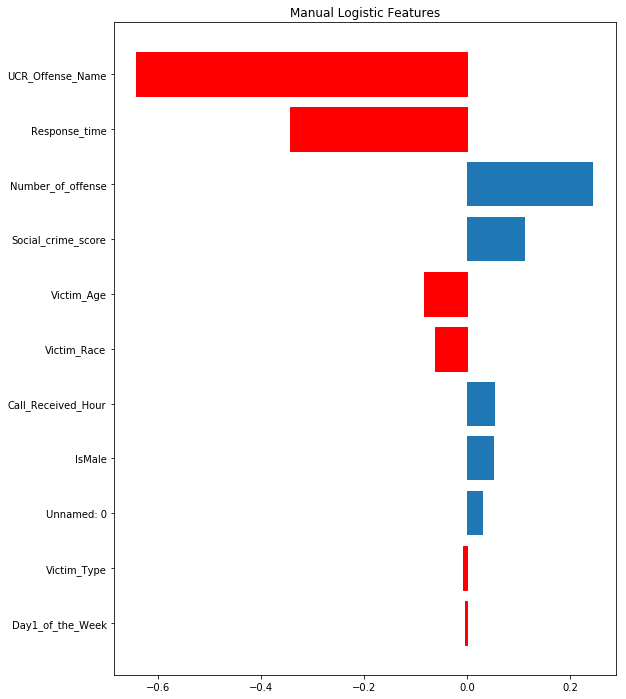

[(-0.6428231081398122, 'UCR_Offense_Name'),
 (-0.3450501753376408, 'Response_time'),
 (-0.08388679116344208, 'Victim_Age'),
 (-0.06322829071287697, 'Victim_Race'),
 (-0.007352674708395218, 'Victim_Type'),
 (-0.00343824277526495, 'Day1_of_the_Week'),
 (0.03166816447952458, 'Unnamed: 0'),
 (0.05233386790657086, 'IsMale'),
 (0.0551017606448946, 'Call_Received_Hour'),
 (0.11314966518287561, 'Social_crime_score'),
 (0.2447650541864018, 'Number_of_offense')]

In [36]:
plotCoef(regGridSearch.best_estimator_.coef_[0], inci_X.columns.values, "Manual Logistic Features")
list(sorted(zip(regGridSearch.best_estimator_.coef_.ravel(), inci_X.columns.values)))

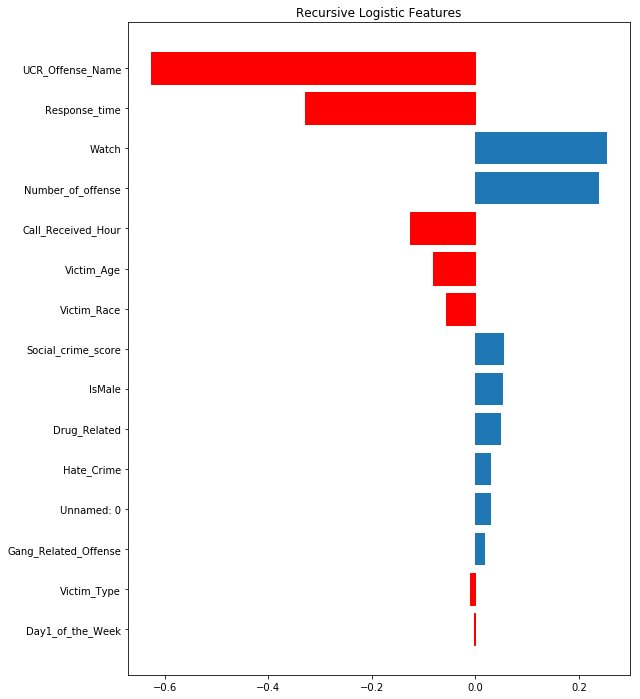

[(-0.6269413618537293, 'UCR_Offense_Name'),
 (-0.3283386558271224, 'Response_time'),
 (-0.1258822471348131, 'Call_Received_Hour'),
 (-0.08253834474289647, 'Victim_Age'),
 (-0.057491067408372225, 'Victim_Race'),
 (-0.01016164085344807, 'Victim_Type'),
 (-0.0036962541514847153, 'Day1_of_the_Week'),
 (0.01875745355664343, 'Gang_Related_Offense'),
 (0.02941553512002592, 'Unnamed: 0'),
 (0.03002811463052817, 'Hate_Crime'),
 (0.049163082335676525, 'Drug_Related'),
 (0.05292918394333855, 'IsMale'),
 (0.05430538232466364, 'Social_crime_score'),
 (0.23958427257698392, 'Number_of_offense'),
 (0.2549659765787247, 'Watch')]

In [37]:
plotCoef(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(), inci_X_Rfe.columns.values, "Recursive Logistic Features")
list(sorted(zip(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(), inci_X_Rfe.columns.values)))

In [38]:
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

model_selection(df_inci_X_SVM_scaled, inci_Y, SGDClassifier())

0.72999804572992

### Interpreting SVM Fields

For SVM models, the interpretation of field importance is not as straight forward. Non-linear SVM models create hyperplanes in infinite dimensional space. To accomplish this the source data used in the analysis must be mapped to a higher dimentional space and as a result is very different from the original data. Because of this it is not possible to determine feature weights like we did with the logisitc regessions above.

However, we can examine individual features to investigate how SVM approaches classification problems.**** EXPLANATION

In [39]:
# #Credit To:
# ####http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
# from matplotlib import pyplot as plt

# #R and RA
# pX = pd.DataFrame()

# pX['a'] = inci_X_SVM['IsMale']
# pX['b'] = inci_X_SVM['Number_of_offense']

# psvc = SVC(kernel='linear', C=0.5, gamma='auto').fit(pX, inci_Y)

# pXAmin = pX['a'].min() - 1
# pXAmax = pX['a'].max() + 1
# pXBmin = pX['b'].min() - 1
# pXBmax = pX['b'].max() + 1

# pxx, pyy = np.meshgrid(np.arange(pXAmin, pXAmax, 10), np.arange(pXBmin, pXBmax, 10))

# plt.subplot(1, 1, 1)

# pZ = psvc.predict(np.c_[pxx.ravel(), pyy.ravel()])

# pZ = pZ.reshape(pxx.shape)
# plt.contourf(pxx, pyy, pZ, cmap=plt.cm.Paired, alpha=0.8)

# plt.scatter(pX['a'], pX['b'], c=inci_Y, cmap=plt.cm.Paired)
# plt.xlabel('UCR_Offense_Name')
# plt.ylabel('Number_of_offense')
# plt.xlim(pxx.min(), pxx.max())
# plt.title('SVM:  UCR_Offense_Name and Number_of_offense')
# plt.show()

# LOGISTIC REGRESSION ROC CURVE

In [40]:
from sklearn.model_selection import train_test_split

# Extract the numpy arrays from the data frame
X = inci_X.as_matrix()
y = inci_Y.as_matrix()

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

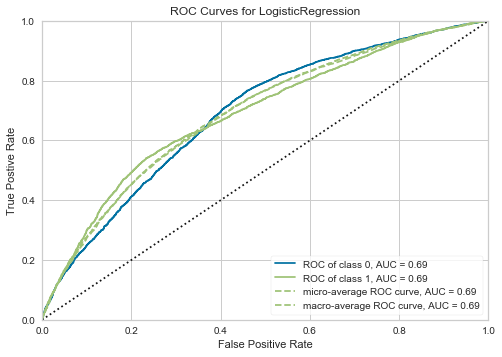

In [41]:
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ROCAUC

# Instantiate the classification model and visualizer
logistic = LogisticRegression()
visualizer = ROCAUC(logistic)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

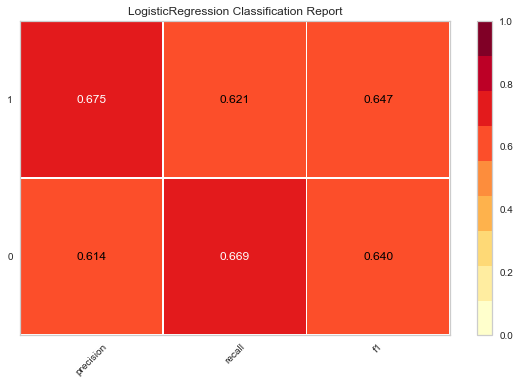

In [42]:
# CLASSIFICATION REPORT
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
viz = ClassificationReport(LogisticRegression())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

# SVM

In [43]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Create classification dataset
X= df_inci_X_SVM_scaled
Y = inci_Y

# classes = ["ARRESTED", "NOT ARRESTED"]
# Perform 80/20 training/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,
                                                    random_state=42)

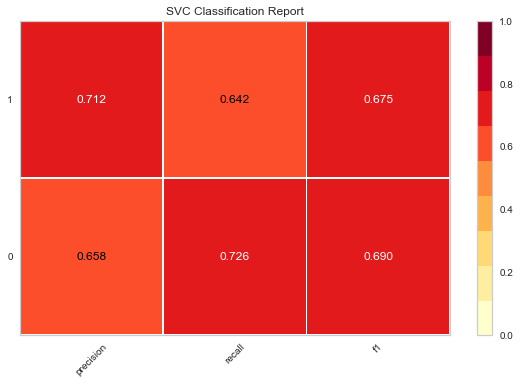

In [44]:
# CLASSIFICATION REPORT
from yellowbrick.classifier import ClassificationReport
# from sklearn.linear_model import SVC
from sklearn.svm import SVC
viz = ClassificationReport(SVC())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

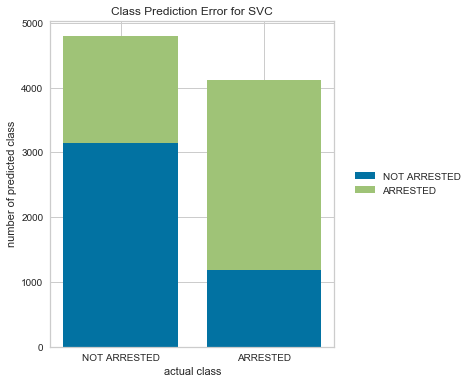

In [45]:
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import ClassPredictionError

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    SVC(), classes=["NOT ARRESTED","ARRESTED"]
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
g = visualizer.poof()

In [46]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from yellowbrick.classifier import ROCAUC

# # Instantiate the classification model and visualizer
# SVM_sample = SVC()
# visualizer = ROCAUC(SVM_sample)

# visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
# visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# g = visualizer.poof()   

###### Key References

https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017ComparingSegregatedHighSchoolCampuses.ipynb (Logit) http://www.cs.toronto.edu/~kswersky/wp-content/uploads/svm_vs_lr.pdf

### END OF REPORT